In [1]:
import pandas as pd
import numpy as np
import requests
import tensorflow as tf
from datetime import datetime, timedelta
import yfinance as yf

# Analisis de sentimientos
import requests
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

# Normalizar datos
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras import Input
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Declarar variables

In [2]:
# News API
url = "https://newsapi.org/v2/everything?" 
API_KEY = "88282befa9004fc388fb57f794bdaefb"
today = datetime.now()
start_date = (today - timedelta(days=31)).strftime("%Y-%m-%d")
end_date = today.strftime("%Y-%m-%d")
# Yfinance
df_netflix_yfinance = yf.download(tickers="NFLX", start=today - timedelta(days=365*3), end=end_date, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
df_netflix_yfinance.columns = [col[0] for col in df_netflix_yfinance.columns]
df_netflix_yfinance.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [4]:
# Configurar modelo FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = TFAutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [5]:
def get_news():
    params = {
        "q": "(Netflix OR NFLX) AND financial",
        "apiKey": API_KEY,
        "language": "en",
        "from": start_date,
        "to": end_date,
        "sortBy": "popularity"
    }
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        articles = data.get("articles", [])
        df_news = pd.DataFrame(articles)
        return df_news
    else:
        raise Exception(f"Error al obtener datos de NewsAPI: {response.status_code} - {response.text}")

In [6]:
df_news = get_news()

In [7]:
def create_combined_text(row):
    title = row.get('title') or ""
    description = row.get('description') or ""
    content = row.get('content') or ""
    return f"{title} {description} {content}".strip()

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=512)
    outputs = model(inputs)
    predictions = tf.nn.softmax(outputs.logits, axis=-1).numpy()[0]
    sentiment = ['positive', 'negative', 'neutral'][predictions.argmax()]
    return sentiment

In [8]:
df_news['combined_text'] = df_news.apply(create_combined_text, axis=1)
df_news

,source,author,title,description,url,urlToImage,publishedAt,content,combined_text
0,"{'id': 'the-verge', 'name': 'The Verge'}",Charles Pulliam-Moore,Netflix’s series about the FTX fiasco has foun...,"Like Amazon and Apple, Netflix is also looking...",https://www.theverge.com/news/676726/netflix-t...,https://platform.theverge.com/wp-content/uploa...,2025-05-29T21:06:11Z,The Altruists has cast Anthony Boyle as Sam Ba...,Netflix’s series about the FTX fiasco has foun...
1,"{'id': None, 'name': 'Gizmodo.com'}",Cheryl Eddy,The ‘Wheel of Time’ Showrunner Still Hopes Its...,The Robert Jordan adaptation was recently canc...,https://gizmodo.com/the-wheel-of-time-showrunn...,https://gizmodo.com/app/uploads/2025/06/wheelo...,2025-06-06T19:00:06Z,Fans haven’t given up on The Wheel of Timethe ...,The ‘Wheel of Time’ Showrunner Still Hopes Its...
2,"{'id': None, 'name': 'NPR'}",Alana Wise,Leaders of 'orgasmic meditation' company were ...,OneTaste billed itself as a sexual wellness bu...,https://www.npr.org/2025/06/11/nx-s1-5429181/o...,https://npr.brightspotcdn.com/dims3/default/st...,2025-06-11T23:24:36Z,This story mentions sexual assault and include...,Leaders of 'orgasmic meditation' company were ...
3,"{'id': None, 'name': 'NPR'}",Mandalit del Barco,Amid global competition for production busines...,Hollywood's plummeting film and TV production ...,https://www.npr.org/2025/05/17/nx-s1-5399795/h...,https://npr.brightspotcdn.com/dims3/default/st...,2025-05-17T11:00:00Z,"On a Hollywood backlot in Los Angeles, you can...",Amid global competition for production busines...
4,"{'id': 'business-insider', 'name': 'Business I...",Dan DeFrancesco,Thinking of making a big financial decision? B...,"From retirement to buying a car, BI examines w...",https://www.businessinsider.com/big-financial-...,https://i.insider.com/68271aa768a29290080181be...,2025-05-16T13:02:11Z,MoMo Productions/Getty Images\r\n<ul><li>This ...,Thinking of making a big financial decision? B...
...,...,...,...,...,...,...,...,...,...
93,"{'id': None, 'name': 'Screen Rant'}",Jordan Lemons,"Move Over, Marvel! Anime Is the Next IP Gold M...","Despite superheroes' resurgence among fans, an...",https://screenrant.com/anime-popularity-global...,https://static1.srcdn.com/wordpress/wp-content...,2025-06-02T01:00:18Z,Animehas no doubt broken out of its bubble to ...,"Move Over, Marvel! Anime Is the Next IP Gold M..."
94,"{'id': None, 'name': 'Screen Rant'}",Grant Hermanns,"""A Very Fine Line Between Love & Hate"": Fear S...",Fear Street: Prom Queen stars India Fowler & F...,https://screenrant.com/fear-street-prom-queen-...,https://static1.srcdn.com/wordpress/wp-content...,2025-05-23T19:15:18Z,Netflix is diving back into the world of R.L. ...,"""A Very Fine Line Between Love & Hate"": Fear S..."
95,"{'id': None, 'name': 'Screen Rant'}",Adam Barnard,Ranking All Of 2025's Canceled Shows From Leas...,We're ranking all of the recently canceled net...,https://screenrant.com/2025-tv-show-cancelatio...,https://static1.srcdn.com/wordpress/wp-content...,2025-06-08T20:20:17Z,As the current network television season winds...,Ranking All Of 2025's Canceled Shows From Leas...
96,"{'id': None, 'name': 'Screen Rant'}",Chris Hedden,The 10 Most Inspirational Moments In Music His...,Here are some of the moments from across music...,https://screenrant.com/inspirational-music-his...,https://static1.srcdn.com/wordpress/wp-content...,2025-05-12T20:00:24Z,When we talk about the brand and the cultural ...,The 10 Most Inspirational Moments In Music His...


In [9]:
#Predecir las noticias por bloques
def predict_sentiment_batch(texts, batch_size=16):
    sentiments = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        
        # Tokenizar lote
        encoded_inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="tf"
        )
        
        # Predicción
        outputs = model(encoded_inputs)
        probs = tf.nn.softmax(outputs.logits, axis=-1).numpy()
        '''
        # Mapear probabilidades a etiquetas
        batch_sentiments = ['positive' if p[0] > p[1] and p[0] > p[2] else 
                            'negative' if p[1] > p[0] and p[1] > p[2] else 
                            'neutral' for p in probs]
        '''
        label_list = ['positive', 'negative', 'neutral']
        batch_sentiments = [ label_list[p.argmax()] for p in probs ]
        sentiments.extend(batch_sentiments)
    
    return sentiments

def predict_sentiment_from_news(df_news, batch_size=16):
    # Preparar texto combinado
    df_news['combined_text'] = df_news.apply(create_combined_text, axis=1)
    df_news['publishedAt'] = pd.to_datetime(df_news['publishedAt']).dt.date

    # Predecir sentimientos en lotes (batches)
    texts = df_news['combined_text'].tolist()
    sentiments = predict_sentiment_batch(texts, batch_size=batch_size)
    df_news['sentiment'] = sentiments
    #df_news['sentiment'] = df_news['combined_text'].apply(predict_sentiment)

    # Agrupar y contar por fecha
    sentiment_counts = df_news.groupby('publishedAt')['sentiment'].value_counts().unstack().fillna(0)
    sentiment_counts.index = pd.to_datetime(sentiment_counts.index)

    # Convertir a lista de diccionarios para cada día
    sentiment_data = []
    for date, row in sentiment_counts.iterrows():
        sentiment_data.append({
            'Date': date,
            'Positive': row.get('positive', 0),
            'Negative': row.get('negative', 0),
            'Neutral': row.get('neutral', 0)
        })

    # Devolver DataFrame con sentimientos diarios
    return pd.DataFrame(sentiment_data).set_index('Date').sort_index()

In [10]:
sentiment_counts = predict_sentiment_from_news(df_news, batch_size=16)
print(sentiment_counts)


            Positive  Negative  Neutral
Date                                   
2025-05-12       1.0       0.0      2.0
2025-05-13       2.0       2.0      1.0
2025-05-14       3.0       2.0      0.0
2025-05-15       2.0       0.0      0.0
2025-05-16       4.0       0.0      0.0
2025-05-17       2.0       1.0      1.0
2025-05-19       4.0       0.0      0.0
2025-05-20       2.0       0.0      0.0
2025-05-21       2.0       4.0      0.0
2025-05-22       3.0       0.0      0.0
2025-05-23       3.0       1.0      0.0
2025-05-24       1.0       0.0      0.0
2025-05-25       1.0       1.0      0.0
2025-05-26       1.0       0.0      0.0
2025-05-27       0.0       1.0      0.0
2025-05-28       3.0       0.0      0.0
2025-05-29       5.0       0.0      0.0
2025-05-30       6.0       0.0      0.0
2025-05-31       1.0       1.0      1.0
2025-06-01       2.0       0.0      0.0
2025-06-02       0.0       1.0      2.0
2025-06-03       5.0       0.0      0.0
2025-06-04       3.0       0.0      0.0


In [11]:
def calculate_technical_indicators(data):
    df = df_netflix_yfinance.copy()
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    
    # MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Otros indicadores
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window=20).std()
    df['Volume_MA'] = df['Volume'].rolling(window=5).mean()
    
    # Rellenar valores faltantes
    #df = df.fillna(method='bfill').fillna(method='ffill')
    df = df.bfill().ffill()
    return df

In [12]:
df_final = calculate_technical_indicators(df_netflix_yfinance)
df_final

,Close,High,Low,Open,Volume,MA5,MA20,MA50,MACD,Signal_Line,RSI,Returns,Volatility,Volume_MA
Date,,,,,,,,,,,,,,
2022-06-14,167.539993,172.059998,164.279999,169.750000,11555300,173.484000,179.766500,207.123800,0.000000,0.000000,62.558210,0.075027,0.033948,11292720.0
2022-06-15,180.110001,183.850006,168.529999,169.259995,12396000,173.484000,179.766500,207.123800,1.002736,0.200547,62.558210,0.075027,0.033948,11292720.0
2022-06-16,173.350006,176.270004,171.559998,174.000000,8201300,173.484000,179.766500,207.123800,1.237669,0.407971,62.558210,-0.037533,0.033948,11292720.0
2022-06-17,175.509995,179.649994,173.339996,173.630005,12133400,173.484000,179.766500,207.123800,1.579935,0.642364,62.558210,0.012460,0.033948,11292720.0
2022-06-21,170.910004,178.619995,169.800003,177.600006,12177600,173.484000,179.766500,207.123800,1.463137,0.806519,62.558210,-0.026209,0.033948,11292720.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-05,1250.520020,1262.810059,1237.290039,1240.599976,2817200,1226.865991,1187.227496,1078.431798,40.615691,41.417928,74.754310,0.008760,0.013961,2906280.0
2025-06-06,1241.469971,1260.000000,1235.550049,1259.410034,2557000,1233.713989,1192.079492,1083.848197,40.194032,41.173149,67.582008,-0.007237,0.013854,2478320.0
2025-06-09,1224.459961,1238.880005,1221.569946,1238.880005,2403100,1234.809985,1196.291492,1088.802997,38.048698,40.548259,60.325930,-0.013702,0.014326,2500100.0


In [13]:
# Paso 3: Fusionar con sentimiento
sentiment_counts = sentiment_counts.reindex(df_final.index, method='ffill').fillna(0)
df_final_bigdata = pd.concat([df_final, sentiment_counts], axis=1).fillna(0)
df_final_bigdata

,Close,High,Low,Open,Volume,MA5,MA20,MA50,MACD,Signal_Line,RSI,Returns,Volatility,Volume_MA,Positive,Negative,Neutral
Date,,,,,,,,,,,,,,,,,
2022-06-14,167.539993,172.059998,164.279999,169.750000,11555300,173.484000,179.766500,207.123800,0.000000,0.000000,62.558210,0.075027,0.033948,11292720.0,0.0,0.0,0.0
2022-06-15,180.110001,183.850006,168.529999,169.259995,12396000,173.484000,179.766500,207.123800,1.002736,0.200547,62.558210,0.075027,0.033948,11292720.0,0.0,0.0,0.0
2022-06-16,173.350006,176.270004,171.559998,174.000000,8201300,173.484000,179.766500,207.123800,1.237669,0.407971,62.558210,-0.037533,0.033948,11292720.0,0.0,0.0,0.0
2022-06-17,175.509995,179.649994,173.339996,173.630005,12133400,173.484000,179.766500,207.123800,1.579935,0.642364,62.558210,0.012460,0.033948,11292720.0,0.0,0.0,0.0
2022-06-21,170.910004,178.619995,169.800003,177.600006,12177600,173.484000,179.766500,207.123800,1.463137,0.806519,62.558210,-0.026209,0.033948,11292720.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-05,1250.520020,1262.810059,1237.290039,1240.599976,2817200,1226.865991,1187.227496,1078.431798,40.615691,41.417928,74.754310,0.008760,0.013961,2906280.0,3.0,0.0,0.0
2025-06-06,1241.469971,1260.000000,1235.550049,1259.410034,2557000,1233.713989,1192.079492,1083.848197,40.194032,41.173149,67.582008,-0.007237,0.013854,2478320.0,4.0,0.0,1.0
2025-06-09,1224.459961,1238.880005,1221.569946,1238.880005,2403100,1234.809985,1196.291492,1088.802997,38.048698,40.548259,60.325930,-0.013702,0.014326,2500100.0,2.0,1.0,0.0


In [28]:
#features = ['Close', 'Volume', 'MA5', 'RSI', 'MACD', 'Signal_Line', 'Returns', 'Volatility', 'Volume_MA', 'Negative','Neutral','Positive']
features = ['Close', 'Volume', 'MA5', 'RSI', 'MACD', 'Signal_Line', 'Returns', 'Volatility', 'Volume_MA']
#features = ['Close', 'Volume', 'High', 'Low', 'Open']

In [29]:
#Prueba
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle
feature_scaler = RobustScaler()
target_scaler = RobustScaler()

In [30]:
# Asegurar tipo float y rellenar faltantes
data = df_final_bigdata[features].astype(float).ffill().bfill()

In [31]:
# Dividir en train/test 70/30
split = int(len(data) * 0.8)
train_data = data.iloc[:split]
test_data = data.iloc[split:]

In [32]:
# Aca estaba tu error, en un modelo nunca se debe entrenar los datos de testeo, solo transformarlos ya que hay data-leak
X_train_scaled = feature_scaler.fit_transform(train_data)
y_train_scaled = target_scaler.fit_transform(train_data[['Close']])

X_test_scaled = feature_scaler.transform(test_data)
y_test_scaled = target_scaler.transform(test_data[['Close']])

In [33]:
# Crear secuencias de entrada -- Modificacion ahora hacer la secuencia en base a los datos de entrenamiento y testing
lookback = 60
X_train, y_train = [], []
for i in range(lookback, len(X_train_scaled)):
    X_train.append(X_train_scaled[i - lookback:i])
    y_train.append(y_train_scaled[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Test
X_test, y_test = [], []
for i in range(lookback, len(X_test_scaled)):
    X_test.append(X_test_scaled[i - lookback:i])
    y_test.append(y_test_scaled[i, 0])

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
#X, y = shuffle(X, y, random_state=42) # No es necesario porque estoy aplicando secuencias y esto al reorganizar aleatoriamente empeorara el modelo

### Aqui acaba la prueba

In [34]:
#del model_LSTM

### Modelo Complejo

In [ ]:
#Puede que sea muy complejo el modelo para los datos
'''
model_LSTM = Sequential()

#model_LSTM.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#model_LSTM.add(Dropout(0.2))

model_LSTM.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

model_LSTM.add(LSTM(units=100, return_sequences=True))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(units=100, return_sequences=True))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(units=100, return_sequences=False))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(Dense(units=1))

optimizer = Adam(learning_rate=0.0005)

# Compilar el modelo
model_LSTM.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
'''

### Modelo Simplificado

In [35]:
model_LSTM = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    LSTM(64, return_sequences=False),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dropout(0.1),

    Dense(1) 
])

optimizer = Adam(learning_rate=0.001)

model_LSTM.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

In [36]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

In [37]:
hist = model_LSTM.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stop], verbose=1)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1263 - mae: 0.2635 - mse: 0.1263 - val_loss: 0.0480 - val_mae: 0.1920 - val_mse: 0.0480
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0218 - mae: 0.1134 - mse: 0.0218 - val_loss: 0.0081 - val_mae: 0.0634 - val_mse: 0.0081
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0145 - mae: 0.0937 - mse: 0.0145 - val_loss: 0.0188 - val_mae: 0.1176 - val_mse: 0.0188
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0160 - mae: 0.0979 - mse: 0.0160 - val_loss: 0.0065 - val_mae: 0.0600 - val_mse: 0.0065
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0116 - mae: 0.0791 - mse: 0.0116 - val_loss: 0.0109 - val_mae: 0.0826 - val_mse: 0.0109
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0115 - mae: 0.0837 - mse: 0.0115 - val_loss: 0.0214 - val_mae: 0.1331 - val_mse: 0.0214
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0091 - mae: 0.0746 - mse: 0.0091 - val

In [38]:
# Predecir y evaluar
predicted_price = model_LSTM.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


'\npredicted_price_unscaled = scaler.inverse_transform(\n    np.hstack((predicted_price, np.zeros((predicted_price.shape[0], data_scaled.shape[1] - 1))))\n)[:, 0]\n\ny_unscaled = scaler.inverse_transform(\n    np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data_scaled.shape[1] - 1))))\n)[:, 0]\n'

In [39]:
predictions_actual = target_scaler.inverse_transform(predicted_price)
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

In [40]:
# Calcular métricas de rendimiento
mse = np.mean((predictions_actual - y_test_actual) ** 2)
mae = np.mean(np.abs(predictions_actual - y_test_actual))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100

In [41]:
# Imprimir métricas
print(f'\nModel Performance:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Absolute Percentage Error: {mape:.2f}%')


Model Performance:
Mean Squared Error: 44477.52
Root Mean Squared Error: 210.90
Mean Absolute Error: 194.94
Mean Absolute Percentage Error: 18.11%


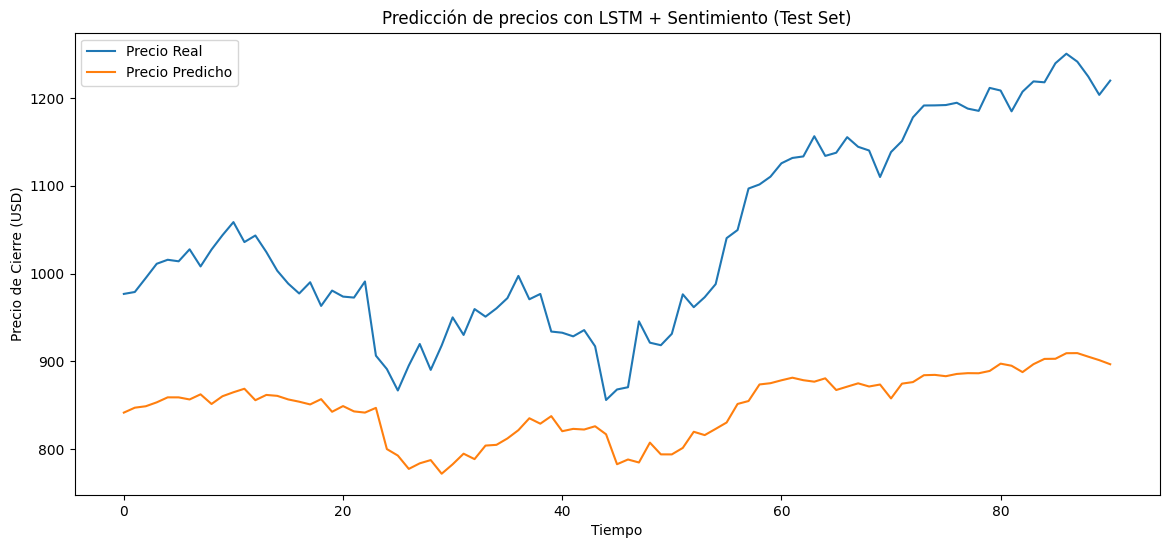

In [42]:
# Crear un DataFrame para facilitar el gráfico
valid = pd.DataFrame()
valid['Real'] = y_test_actual.ravel()
valid['Predicción'] = predictions_actual.ravel()

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(valid['Real'].values, label='Precio Real')
plt.plot(valid['Predicción'].values, label='Precio Predicho')
plt.title('Predicción de precios con LSTM + Sentimiento (Test Set)')
plt.xlabel('Tiempo')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.show()

#### Podemos concluir segun internet:
    - MAPE < 10% = esta en un rango aceptable
    - MAPE < 9% = esta en un rango aceptable
    - RMSE 64 = Si es se predice si sube o baja la accion maximo habra una diferencia de 64$ aunque en algunos casos puede variar

## Vamos a probar con un modelo GRU

In [56]:
#features = ['Close', 'Volume', 'High', 'Low', 'Open']
#features = ['Close', 'Volume', 'MA5', 'RSI', 'MACD', 'Signal_Line', 'Returns', 'Volatility', 'Volume_MA', 'Negative','Neutral','Positive']
features = ['Close', 'Volume', 'MA5', 'RSI', 'MACD', 'Signal_Line', 'Returns', 'Volatility', 'Volume_MA']

In [57]:
data = df_final_bigdata[features].astype(float).ffill().bfill()

In [58]:
# Escalado
feature_scaler = RobustScaler()
target_scaler = RobustScaler()

X_scaled = feature_scaler.fit_transform(data)
y_scaled = target_scaler.fit_transform(data[['Close']])

# Train/Test split
split = int(len(data) * 0.8)
X_train_scaled = X_scaled[:split]
y_train_scaled = y_scaled[:split]
X_test_scaled = X_scaled[split:]
y_test_scaled = y_scaled[split:]

In [59]:
# Secuencias con lookback
lookback = 60

def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i, 0])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, lookback)

In [61]:
#del model_GRU

In [62]:
# Modelo GRU
model_GRU = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(units=64, return_sequences=False),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dropout(0.1),
    Dense(units=1)
])

optimizer = Adam(learning_rate=0.001)
model_GRU.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

In [63]:
hist = model_GRU.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/100
31/31 - 2s - 74ms/step - loss: 0.0618 - mae: 0.1887 - mse: 0.0618 - val_loss: 0.0520 - val_mae: 0.1453 - val_mse: 0.0520
Epoch 2/100
31/31 - 0s - 15ms/step - loss: 0.0202 - mae: 0.1123 - mse: 0.0202 - val_loss: 0.0368 - val_mae: 0.1255 - val_mse: 0.0368
Epoch 3/100
31/31 - 0s - 15ms/step - loss: 0.0154 - mae: 0.0970 - mse: 0.0154 - val_loss: 0.0193 - val_mae: 0.0815 - val_mse: 0.0193
Epoch 4/100
31/31 - 0s - 16ms/step - loss: 0.0135 - mae: 0.0891 - mse: 0.0135 - val_loss: 0.0222 - val_mae: 0.1057 - val_mse: 0.0222
Epoch 5/100
31/31 - 0s - 14ms/step - loss: 0.0107 - mae: 0.0795 - mse: 0.0107 - val_loss: 0.0103 - val_mae: 0.0608 - val_mse: 0.0103
Epoch 6/100
31/31 - 0s - 14ms/step - loss: 0.0097 - mae: 0.0752 - mse: 0.0097 - val_loss: 0.0090 - val_mae: 0.0550 - val_mse: 0.0090
Epoch 7/100
31/31 - 0s - 13ms/step - loss: 0.0086 - mae: 0.0717 - mse: 0.0086 - val_loss: 0.0077 - val_mae: 0.0556 - val_mse: 0.0077
Epoch 8/100
31/31 - 0s - 13ms/step - loss: 0.0086 - mae: 0.0704 - mse

In [64]:
predicted_price = model_GRU.predict(X_test)
predictions_actual = target_scaler.inverse_transform(predicted_price)
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [65]:
# Métricas
mse = np.mean((predictions_actual - y_test_actual) ** 2)
mae = np.mean(np.abs(predictions_actual - y_test_actual))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100
print(f"\nModel Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Model Performance:
Mean Squared Error: 14720.69
Root Mean Squared Error: 121.33
Mean Absolute Error: 108.26
Mean Absolute Percentage Error: 9.96%


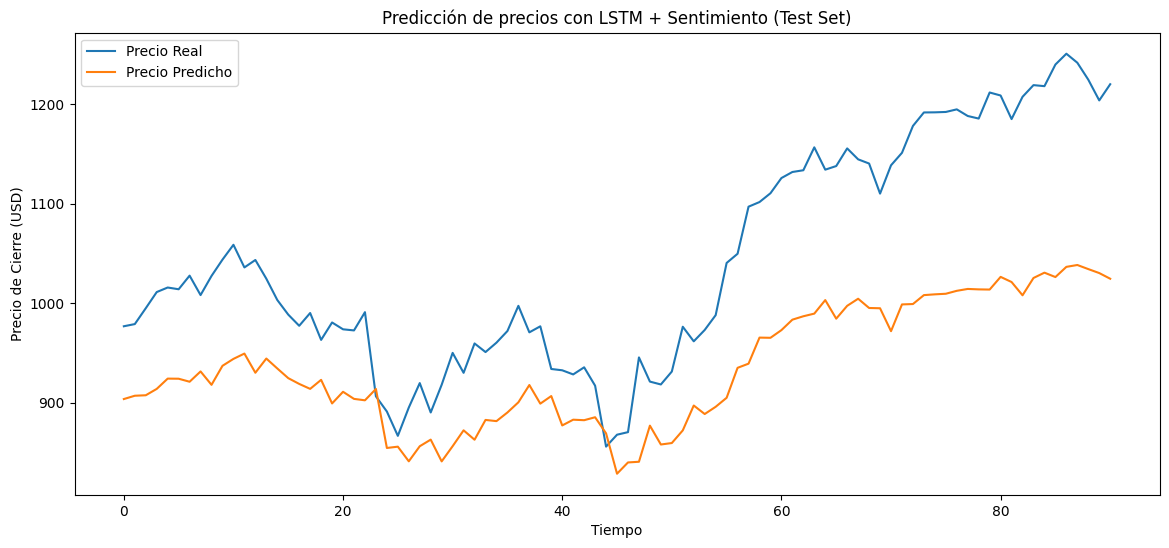

In [66]:
# Crear un DataFrame para facilitar el gráfico
valid = pd.DataFrame()
valid['Real'] = y_test_actual.ravel()
valid['Predicción'] = predictions_actual.ravel()

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(valid['Real'].values, label='Precio Real')
plt.plot(valid['Predicción'].values, label='Precio Predicho')
plt.title('Predicción de precios con LSTM + Sentimiento (Test Set)')
plt.xlabel('Tiempo')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.show()